Prompt:
Take two hours and do as much as you can of the following (feel free to use whichever tools and technology you are most comfortable with):

1.      Download this dataset. (http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls)

2.      Explore and describe the dataset (charts, written descriptions, or whatever you think fits best).

3.      Pick and describe an appropriate model to quickly predict the target outcome of this dataset (survival).

4.      How would you handle missing data? What are some potential pitfalls?

5.      Rank each feature in order of importance.

6.      Fit a simple model of your choice and show how well it predicts.

7.      What steps would you take to improve this model?

I am not familiar with this data set and was supplied no data dictionary.  Poking around on the website link also didn't seem to yield any quick results.  However, the name and the fields lead me to believe that this is some type of data set related to the famous HMS Titanic disaster.  I'll try to go along and write down observations as I code an exploration.

In [4]:
import matplotlib as plt
import pandas as pd
import numpy as np

from sklearn import cross_validation, linear_model, metrics

%matplotlib inline

In [5]:
titanic_xls = pd.read_excel('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls')
titanic_xls.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


14 fields exist in what looks like:
* a class of passenger
* a binary indicator on whether or not they survived the disaster
* the name, sex, and age of the passenger
* two fields that I'm not quite sure about
* what looks like a ticket number (possibly grouped by family or cabins)
* the fare paid
* some cabin identifiers
* a field called embarked that may or may not indicate whether the passengers began the journey or not
* a field called "boat" that may refer to the boat the passengers survived on
* a field called "body" that may refer to an identifier if they didn't survive
* their destination

In [6]:
titanic_xls.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


Much of the above is useless, as pclass I'm sure is a discrete field.  38% of the passengers survived if that field is in fact a binary indicator.  The passengers were slightly younger than 30, with a really young baby but at least a few 80 year olds aboard.  'parch' is still a mystery.  The median fare is about 14 somethings (I'll assume pounds through the rest of this as they were traveling out of jolly old England) with most people paying in the 14-30 pound range, although one person has paid 512 pounds for the pleasure of journeying on this cruise.

In [7]:
titanic_xls['sex'].value_counts()

male      843
female    466
Name: sex, dtype: int64

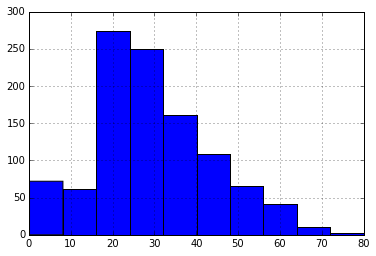

In [8]:
titanic_xls['age'].hist()

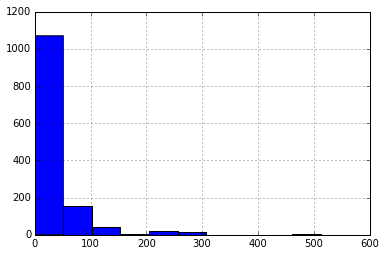

In [9]:
titanic_xls['fare'].hist()

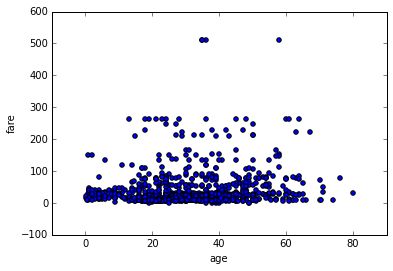

In [10]:
titanic_xls.plot.scatter(x='age', y='fare')

I thought there might be a nifty "older people pay more because they have more money" thing that goes on in some financial data sets, but it looks like the titanics passengers all paid alike regardless of their age.

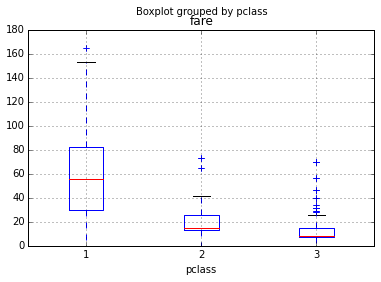

In [11]:
fare = titanic_xls[titanic_xls['fare']<200].boxplot(column='fare', by='pclass')

The pclass field does indeed seem to match intuition as a class of passenger.  The fare boxplots shown here (with outliers removed to give a better visualisation of spread) show the same as the fare description above.  We could probably break this field down more if we cared about investigating this type of thing but I'll leave it at this for the moment.

In [12]:
titanic_xls.embarked.value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

In [13]:
titanic_xls.groupby('survived')['embarked'].value_counts()

survived  embarked
0         S           610
          C           120
          Q            79
1         S           304
          C           150
          Q            44
dtype: int64

Originally I thought that perhaps we could exclude some passengers by dent of their not actually being on board the boat when it set sail.  Alas, it appears as though no easy win can be had as members of all three types of 'embarked' both lived and died as matters had it.

In [14]:
titanic_xls['home.dest'].value_counts()

New York, NY                                 64
London                                       14
Montreal, PQ                                 10
Paris, France                                 9
Cornwall / Akron, OH                          9
Philadelphia, PA                              8
Winnipeg, MB                                  8
Wiltshire, England Niagara Falls, NY          8
Belfast                                       7
Brooklyn, NY                                  7
Sweden Winnipeg, MN                           7
Rotherfield, Sussex, England Essex Co, MA     5
Bulgaria Chicago, IL                          5
Somerset / Bernardsville, NJ                  5
Sweden Worcester, MA                          5
Haverford, PA / Cooperstown, NY               5
Ottawa, ON                                    5
Minneapolis, MN                               4
Syria New York, NY                            4
Ruotsinphytaa, Finland New York, NY           4
Bryn Mawr, PA                           

I don't really understand the destinations as if the Titanic was sailing from England why would you book passage to London but perhaps round trip tickets or tickets good for a certain amount of time with an eventual destination were issued back then.

In [15]:
tot = len(titanic_xls)
survived = len(titanic_xls[titanic_xls['survived']==1])
dead = tot - survived

survived_and_body_recovered = titanic_xls[(titanic_xls['survived']==1) & titanic_xls['body']]
dead_and_body_recovered = titanic_xls[(titanic_xls['survived']==0) & titanic_xls['body']]

survived_and_boat = titanic_xls[(titanic_xls['survived']==1) & titanic_xls['boat']]
dead_and_boat = titanic_xls[(titanic_xls['survived']==0) & (titanic_xls['boat'])]


print "{} of passengers in the data set".format(tot)
print "{} passengers who survived".format(survived)
print "{} passengers who did not survive".format(dead)
print "{} passengers who survived and who have something listed in the body column".format(len(survived_and_body_recovered))
print "{} passengers who did not survive and who have something listed in the body column".format(len(dead_and_body_recovered))
print "{} passengers who did survived and who have something listed in the boat column".format(len(survived_and_boat))
print "{} passengers who did not survive and who have something listed in the boat column".format(len(dead_and_boat))

1309 of passengers in the data set
500 passengers who survived
809 passengers who did not survive
0 passengers who survived and who have something listed in the body column
121 passengers who did not survive and who have something listed in the body column
477 passengers who did survived and who have something listed in the boat column
9 passengers who did not survive and who have something listed in the boat column


Initially I thought that the body field might be the identifier of the body that was found later on and thus would be an insufficient field to predict on.  The above confirms this as no one who survived has a body associated.  A sobering 809 passengers did not survive however, although from the movie and my limited knowledge of the event, I didn't imagine that 500 had survived, so thats nice.

What's more puzzling is how 23 of them did it without a boat being associated with the rescue.  Perhaps an error in the data?  I'm not sure what it is but it shouldn't affect what we're trying to predict so I'll leave it at that.

In [16]:
titanic_xls.groupby('sex')['survived'].value_counts(normalize=True).sort_index()

sex     survived
female  0           0.272532
        1           0.727468
male    0           0.809015
        1           0.190985
dtype: float64

In [17]:
titanic_xls.groupby('pclass')['survived'].value_counts(normalize=True).sort_index()

pclass  survived
1       0           0.380805
        1           0.619195
2       0           0.570397
        1           0.429603
3       0           0.744711
        1           0.255289
dtype: float64

In [18]:
titanic_xls.groupby(['pclass', 'sex'])['survived'].value_counts(normalize=True).sort_index()

pclass  sex     survived
1       female  0           0.034722
                1           0.965278
        male    0           0.659218
                1           0.340782
2       female  0           0.113208
                1           0.886792
        male    0           0.853801
                1           0.146199
3       female  0           0.509259
                1           0.490741
        male    0           0.847870
                1           0.152130
dtype: float64

According to the famous cry "women and children first" it makes sense that females have a 3 to 1 odds of making it alive off the boat however, we should wrinkle our noses at the fact that it seems to be interesting that male passengers riding in first class end up surviving more often than their bretheren in second and third class.

In [25]:
data = titanic_xls[['pclass', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'cabin']]
label = titanic_xls['survived']

scores = cross_validation.cross_val_score(LogisticRegression(), data, label, scoring='accuracy', cv=10)
print scores
print scores.mean()

Logistic regression parameter weights are useless for feature selection as well known, but its fairly clear that pclass, sex, age, seem to have the most importance in whether or not someone survived the Titanic attempt.  T